In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import lightgbm as lgb
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, recall_score, accuracy_score, auc, classification_report, \
                            confusion_matrix, plot_confusion_matrix, precision_recall_curve, \
                            plot_precision_recall_curve, roc_curve, plot_roc_curve)

In [2]:
#!pip install shap

In [3]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
from tqdm import tqdm

In [6]:
!pip install catboost

In [7]:
import catboost as cb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

warnings.simplefilter("ignore")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
test_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_test.csv'

In [10]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/data_HW2/assignment_2_train.csv'

In [11]:
data = pd.read_csv(train_path)

In [12]:
test = pd.read_csv(test_path)

In [13]:
target = data["isFraud"]
data = data.drop(["isFraud"], axis=1)

numerical_features_train = data.select_dtypes(include=np.number)
categorical_features_train = data.select_dtypes(include=["object"])

In [14]:
numerical_features_test = test.select_dtypes(include=np.number)
categorical_features_test = test.select_dtypes(include=["object"])

In [15]:
# список признаков с категорией object на трейне
obj_list = categorical_features_train.columns.to_list()
obj_list, len(obj_list)

(['ProductCD',
  'card4',
  'card6',
  'P_emaildomain',
  'R_emaildomain',
  'M1',
  'M2',
  'M3',
  'M4',
  'M5',
  'M6',
  'M7',
  'M8',
  'M9'],
 14)

In [16]:
# переведём пропуски в пустое значение и в строку (для теста и для трейна)
for feature in obj_list:
    data[feature] = categorical_features_train.fillna('')
    data[feature] = categorical_features_train[feature].astype('str')
    test[feature] = categorical_features_test.fillna('')
    test[feature] = categorical_features_test[feature].astype('str')

In [17]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=1,
)


x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=42
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=42
)

In [18]:
y_lead = test['isFraud']
x_lead = test.drop('isFraud', axis=1)

In [19]:
train_pool = cb.Pool(x_train, y_train, cat_features=obj_list)
valid_pool = cb.Pool(x_valid, y_valid, cat_features=obj_list)

In [20]:
cb_params = {
    "n_estimators": 1400,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 35,
    "thread_count": -1,
    "random_seed": 25
}

In [21]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(train_pool, eval_set=valid_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6381289	best: 0.6381289 (0)	total: 524ms	remaining: 12m 12s
50:	test: 0.8500685	best: 0.8501336 (47)	total: 24.4s	remaining: 10m 45s
100:	test: 0.8620131	best: 0.8620131 (100)	total: 48.9s	remaining: 10m 28s
150:	test: 0.8685046	best: 0.8685046 (150)	total: 1m 13s	remaining: 10m 8s
200:	test: 0.8758660	best: 0.8758671 (199)	total: 1m 38s	remaining: 9m 48s
250:	test: 0.8822371	best: 0.8822371 (250)	total: 2m 3s	remaining: 9m 26s
300:	test: 0.8849140	best: 0.8849140 (300)	total: 2m 28s	remaining: 9m
350:	test: 0.8876846	best: 0.8876846 (350)	total: 2m 52s	remaining: 8m 36s
400:	test: 0.8890385	best: 0.8890388 (399)	total: 3m 16s	remaining: 8m 9s
450:	test: 0.8902269	best: 0.8902269 (450)	total: 3m 40s	remaining: 7m 43s
500:	test: 0.8907953	best: 0.8908266 (491)	total: 4m 3s	remaining: 7m 17s
550:	test: 0.8912281	best: 0.8912315 (549)	total: 4m 26s	remaining: 6m 51s
600:	test: 0.8918291	best: 0.8918291 (600)	total: 4m 51s	remaining: 6m 27s
650:	test: 0.8921536	best: 0.8921618 (

In [22]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_cb.predict_proba(x_train)[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_test, model_cb.predict_proba(x_test)[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_valid, model_cb.predict_proba(x_valid)[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_cb.predict_proba(x_lead)[:, 1]), 3)}")

ROC AUC train = 0.905
ROC AUC valid = 0.9
ROC AUC test = 0.892
ROC AUC leaderboard = 0.861


In [23]:
x_valid_, y_valid_ = x_valid.sample(10000), y_valid.sample(10000)

explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(x_valid_, y_valid_)

In [24]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid_.iloc[0,:], link="logit"
)

## Гистограмма важности признаков

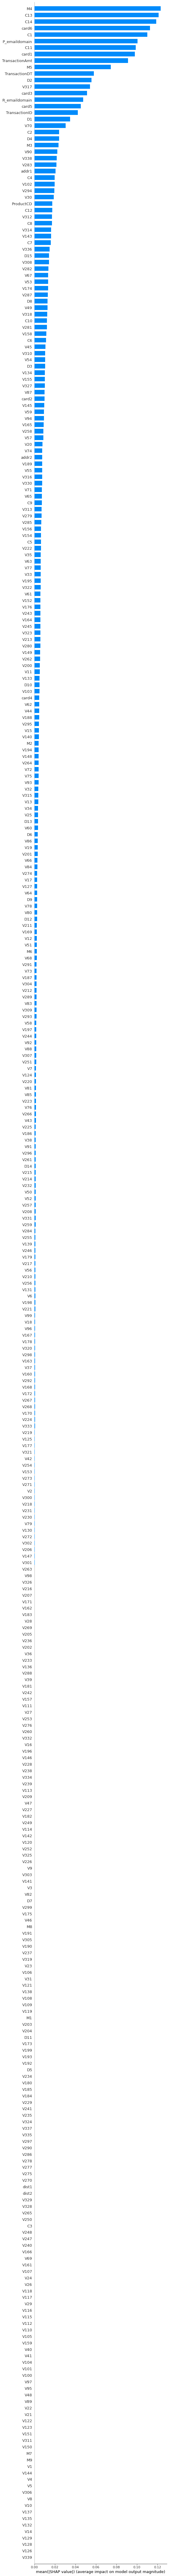

In [25]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=x_valid_.shape[1])

In [26]:
# Извлекаем фичи по важности 
shap_sum = np.abs(shap_values).mean(axis=0)
importance_feature = pd.DataFrame([x_valid.columns.tolist(), shap_sum.tolist()]).T
importance_feature.columns = ['column_name', 'shap_importance']
importance_feature = importance_feature.sort_values('shap_importance', ascending=False)
importance_feature

,column_name,shap_importance
48,M4,0.123148
28,C13,0.121262
29,C14,0.118839
9,card6,0.112712
16,C1,0.110115
...,...,...
182,V129,0
181,V128,0
179,V126,0
176,V123,0


In [27]:
importance_top = importance_feature[importance_feature['shap_importance']>0][:100]

In [28]:
importance_top

,column_name,shap_importance
48,M4,0.123148
28,C13,0.121262
29,C14,0.118839
9,card6,0.112712
16,C1,0.110115
...,...,...
298,V245,0.00583366
376,V323,0.00583034
266,V213,0.00577627
333,V280,0.00576172


In [29]:
top_shap = importance_top['column_name'].to_list()

In [30]:
len(top_shap)

100

In [31]:
top_shap

['M4',
 'C13',
 'C14',
 'card6',
 'C1',
 'P_emaildomain',
 'C11',
 'card1',
 'TransactionAmt',
 'M5',
 'TransactionDT',
 'D2',
 'V317',
 'card3',
 'R_emaildomain',
 'card5',
 'TransactionID',
 'D1',
 'V70',
 'C2',
 'D4',
 'M3',
 'V90',
 'V338',
 'V283',
 'addr1',
 'C4',
 'V102',
 'V294',
 'V30',
 'ProductCD',
 'C12',
 'V312',
 'C8',
 'V314',
 'V143',
 'C7',
 'V336',
 'D15',
 'V308',
 'V282',
 'V67',
 'V53',
 'V174',
 'V287',
 'D8',
 'V49',
 'V318',
 'C10',
 'V281',
 'V158',
 'C6',
 'V45',
 'V310',
 'V54',
 'D3',
 'V134',
 'V155',
 'V327',
 'V87',
 'card2',
 'V145',
 'V59',
 'V94',
 'V165',
 'V258',
 'V57',
 'V20',
 'V74',
 'addr2',
 'V189',
 'V55',
 'V316',
 'V330',
 'V71',
 'V65',
 'C9',
 'V313',
 'V279',
 'V285',
 'V156',
 'V154',
 'C5',
 'V222',
 'V35',
 'V63',
 'V77',
 'V33',
 'V195',
 'V322',
 'V61',
 'V152',
 'V176',
 'V243',
 'V164',
 'V245',
 'V323',
 'V213',
 'V280',
 'V149']

In [32]:
cat_top_shop=[]

In [33]:
for feat in top_shap: 
  if feat in set(categorical_features_train): 
    cat_top_shop.append(feat)

In [34]:
cat_top_shop

['M4', 'card6', 'P_emaildomain', 'M5', 'R_emaildomain', 'M3', 'ProductCD']

In [35]:
y_lead = test['isFraud']
x_lead = test.drop('isFraud', axis=1)

In [41]:
train_pool_2 = cb.Pool(x_train[top_shap], y_train, cat_features=cat_top_shop)
valid_pool_2 = cb.Pool(x_valid[top_shap], y_valid, cat_features=cat_top_shop)

In [42]:
cb_params = {
    "n_estimators": 1400,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 35,
    "thread_count": -1,
    "random_seed": 17
}

In [43]:
model_cb_2 = cb.CatBoostClassifier(**cb_params)
model_cb_2.fit(train_pool_2, eval_set=valid_pool_2, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6503509	best: 0.6503509 (0)	total: 251ms	remaining: 5m 51s
50:	test: 0.8545359	best: 0.8545359 (50)	total: 12.3s	remaining: 5m 25s
100:	test: 0.8648181	best: 0.8648181 (100)	total: 24.4s	remaining: 5m 13s
150:	test: 0.8730096	best: 0.8730096 (150)	total: 36.2s	remaining: 4m 59s
200:	test: 0.8790005	best: 0.8790009 (198)	total: 48.4s	remaining: 4m 48s
250:	test: 0.8857166	best: 0.8857166 (250)	total: 1m	remaining: 4m 36s
300:	test: 0.8889222	best: 0.8889222 (300)	total: 1m 12s	remaining: 4m 24s
350:	test: 0.8907642	best: 0.8907642 (350)	total: 1m 24s	remaining: 4m 12s
400:	test: 0.8920917	best: 0.8920917 (400)	total: 1m 35s	remaining: 3m 57s
450:	test: 0.8930944	best: 0.8930978 (449)	total: 1m 45s	remaining: 3m 42s
500:	test: 0.8931473	best: 0.8931507 (490)	total: 1m 55s	remaining: 3m 26s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.8931507103
bestIteration = 490

Shrink model to first 491 iterations.


In [40]:
print(f"ROC AUC train = {round(roc_auc_score(y_train, model_cb_2.predict_proba(x_train[top_shap])[:, 1]), 3)}")
print(f"ROC AUC valid = {round(roc_auc_score(y_test, model_cb_2.predict_proba(x_test[top_shap])[:, 1]), 3)}")
print(f"ROC AUC test = {round(roc_auc_score(y_valid, model_cb_2.predict_proba(x_valid[top_shap])[:, 1]), 3)}")
print(f"ROC AUC leaderboard = " +
    f"{round(roc_auc_score(y_lead, model_cb_2.predict_proba(x_lead[top_shap])[:, 1]), 3)}")

ROC AUC train = 0.908
ROC AUC valid = 0.902
ROC AUC test = 0.893
ROC AUC leaderboard = 0.86


In [44]:
#ROC AUC train = 0.905
#ROC AUC valid = 0.9
#ROC AUC test = 0.892
#ROC AUC leaderboard = 0.861
# Shapley score
#ROC AUC train = 0.908
#ROC AUC valid = 0.902
#ROC AUC test = 0.893
#ROC AUC leaderboard = 0.86

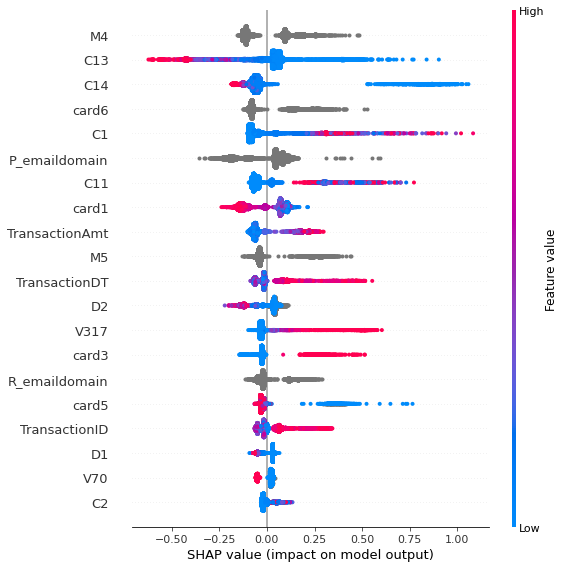

In [45]:
shap.summary_plot(shap_values, x_valid_)

- Признаки C13, C14, С11, C1, card5 сильнее всего влияют на модель. 

Explainer expected value: [-4.39992276]


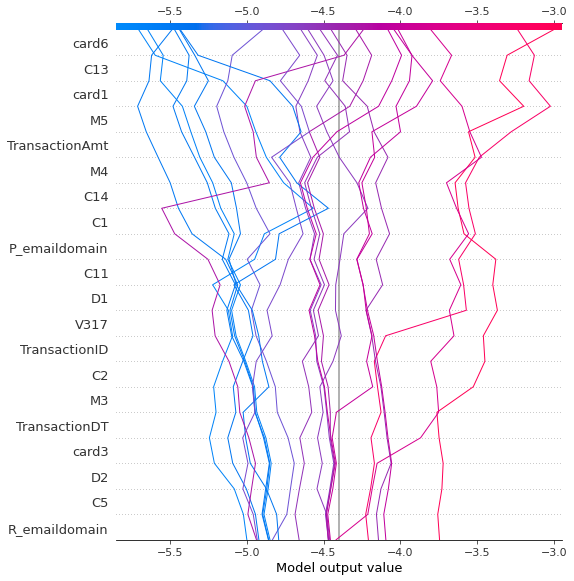

In [61]:
explainer = shap.TreeExplainer(model_cb_2)
expected_value = explainer.expected_value
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_valid[top_shap].iloc[select]
features_display = x_valid[top_shap].loc[features.index]
shap_values = explainer.shap_values(features)
shap.decision_plot(expected_value, shap_values, features_display)

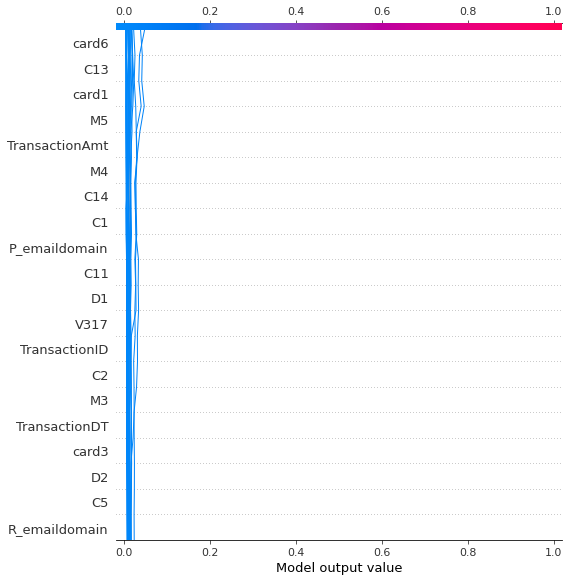

In [64]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")